In [1]:
from IPython.display import Markdown, display
import sys
import copy
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev as sd, mean
from scipy.stats import randint as sp_randint, uniform
import time

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas,\
                    load_preproc_data_adult_5att, load_preproc_data_artificial, \
                    load_preproc_data_adult_continuous, load_preproc_data_german_continuous
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from common_utils import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn import svm, datasets
from sklearn.datasets import load_digits, load_iris, make_hastie_10_2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

sys.path.append('/home/andrew/python-virtual-environments/hyperband/scikit-hyperband/hyperband')
from miti_search import HyperbandSearchCV

import pickle
filename = 'X_y_weight'
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()
filename = 'X_y_data_info_compas_step_2'
infile = open(filename,'rb')
transf_data_info = pickle.load(infile)
infile.close()

# X = new_dict['X']
# y = new_dict['y']
# sample_dict = new_dict['weights']
# thresh = new_dict['thresh']
# train = new_dict['train']
# test = new_dict['test']
# indexes = new_dict['unique']
# instance_base = new_dict['instance_weights']
# len(sample_dict[0]['sample_weight'])
# sample_dict[4]['sample_weight'][:7]

In [2]:
X_check = transf_data_info['X']
y_check = transf_data_info['y']
w_check = transf_data_info['og_w']
og_pred = transf_data_info['y_pred']
bin_pred = transf_data_info['y_bin_pred']
thresh = transf_data_info['thresh']
test_ind = transf_data_info['test_ind']
sample_dict = transf_data_info['sample_dict']
print(X_check[0])
print(f'y:{sum(y_check)}, y_pred:{sum(og_pred)}, thresh:{thresh}, test_ind:{test_ind}, len(sample_dict):{len(sample_dict)}')
print(np.unique(w_check['sample_weight'], return_index=True))

[ 2.0288774   1.23140114 -1.16635474  1.9812454  -0.53205677 -0.68681376
  1.32076793 -0.67829127 -1.39154842  1.39154842]
y:2081.0, y_pred:[434.36399946], thresh:0.5148484848484849, test_ind:792, len(sample_dict):3234
(array([0.8767228 , 0.90015204, 1.102208  , 1.20221008]), array([ 2,  5, 10,  0]))


In [3]:
lmod = LogisticRegression()
lmod.fit(X_check[test_ind:,], y_check[test_ind:], w_check['sample_weight'][test_ind:])
y_train_pred = lmod.predict(X_check[test_ind:,])
y_test_pred = lmod.predict_proba(X_check[:test_ind])[:,0].reshape(-1,1)

transformed_binary_data = [int(i[0]) for i in bin_pred] # orig values form RWfor comparison (only is tester is included in dict) 
y_binary = [0 if i >= thresh else 1 for i in y_test_pred]

print(y_binary[:15])
print(np.array_equal(y_test_pred, og_pred))
print('accu: ', accuracy_score(y_binary, y_check[:test_ind]))
print('bal acc: ', balanced_accuracy_score(y_binary, y_check[:test_ind]))

priv, unpriv, p_pos, u_pos, p_tp, u_tp, pred_p_pos, pred_u_pos = 0,0,0,0,0,0,0,0

for i in range(len(X_check[:test_ind][:,1])):
    if X_check[:test_ind][:,1][i] > 0:
        priv +=1
        if y_check[:test_ind][i] == 0:
            p_pos +=1
            if y_binary[i] == 0:
                p_tp +=1
        if y_binary[i] == 0:
            pred_p_pos +=1
    else:
        unpriv +=1
        if y_check[:test_ind][i] == 0:
            u_pos +=1
            if y_binary[i] == 0:
                u_tp +=1
        if y_binary[i] == 0:
            pred_u_pos +=1
    
total = len(y_binary)
print(total)
print(priv, unpriv, p_pos, u_pos, p_tp, u_tp)
print('percent priv:', priv/total)
print('percent posi:', (p_pos+u_pos)/total)
print('percent pred:', (pred_p_pos+pred_u_pos)/total)
print("TPR", p_tp/p_pos, u_tp/u_pos, (p_tp+u_tp)/(p_pos+u_pos), 'TP-Ratio:', (u_tp/u_pos)/(p_tp/p_pos))
print('disp_imp:', (pred_u_pos/unpriv)/(pred_p_pos/priv))

pos, neg, tps, tns = 0,0,0,0

for i in range(len(y_binary)):
    if y_check[:7327][i] == 1:
        pos += 1
        if y_binary[i] == 1:
            tps +=1
    else:
        neg += 1
        if y_binary[i] == 0:
            tns +=1

print(pos, neg, tps, tns)
trrs = tps/pos
tnrs = tns/neg

bal_acc = 0.5*(trrs+tnrs)
print('bal_acc:', bal_acc)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
True
accu:  0.6338383838383839
bal acc:  0.6355259345117357
792
319 473 192 201 120 149
percent priv: 0.4027777777777778
percent posi: 0.4962121212121212
percent pred: 0.5492424242424242
TPR 0.625 0.7412935323383084 0.6844783715012722 TP-Ratio: 1.1860696517412934
disp_imp: 1.0928831605491733
399 393 233 269
bal_acc: 0.6342191356253228


In [4]:
total_time = []
for i in range(1):
    start_time = time.time()
    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 1 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=0
    ne=1
    att=1

    is_distribution = True

    if is_distribution:
        sample_dict = uniform_weights

    search = HyperbandSearchCV(model, param_dist, 
                               resource_param='max_iter',
                               scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=sample_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po, ne, att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
# print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

6.4108500480651855


In [5]:
indexes=[0,2,3,6]
working_dict = search.data_list.copy()
hyper_band_bracket = working_dict[-1]
working_dict[-1].pop('hyperband_bracket')

for i in working_dict:
    for j in range(len(i['param_sample_weight'])):
        unique_weights = []
        for k in indexes:
            unique_weights.append(i['param_sample_weight'][j][k])
        i['param_sample_weight'][j] = unique_weights
    i.pop('params') 
df = pd.DataFrame()
for dict_array in search.data_list:
    df = pd.concat([df, pd.DataFrame.from_dict(dict_array)], sort=False)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_acc,std_test_acc,mean_test_ba,std_test_ba,mean_test_pp,std_test_pp,...,std_test_tradeoff_met,param_sample_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041573,0.016822,0.002452,0.000620,0.656486,0.011718,0.601740,0.049476,0.554612,0.012797,...,0.049476,"[1, 1, 1, 1]",0.671808,0.607894,0.516587,0.605432,0.606978,0.601755,0.049482,81
1,0.002180,0.000079,0.002425,0.000210,0.645791,0.016100,0.693455,0.051340,0.535886,0.015281,...,0.051340,"[1.2022100781746017, 0.8767228032181157, 0.876...",0.769574,0.667247,0.618413,0.686644,0.725398,0.693472,0.051347,1
2,0.002056,0.000173,0.002088,0.000295,0.649804,0.022495,0.638524,0.066684,0.552385,0.033236,...,0.066684,"[1.1, 0.94, 0.94, 0.98]",0.759535,0.625338,0.559152,0.605432,0.643161,0.638550,0.066701,62
3,0.002224,0.000358,0.002022,0.000124,0.650473,0.020952,0.649719,0.061596,0.560189,0.017654,...,0.061596,"[1.07, 0.89, 0.89, 0.91]",0.769574,0.625338,0.602598,0.607923,0.643161,0.649745,0.061615,26
4,0.001963,0.000115,0.001942,0.000069,0.651142,0.020593,0.648218,0.059996,0.560413,0.018276,...,0.059996,"[1.14, 0.94, 0.94, 0.92]",0.764564,0.625338,0.602598,0.605432,0.643161,0.648244,0.060014,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.005009,0.000803,0.002456,0.000732,0.666518,0.012753,0.731751,0.071808,0.594066,0.012229,...,0.071808,"[1.17, 0.94, 0.94, 0.99]",0.850084,0.704243,0.671894,0.657275,0.775260,0.731777,0.071822,41
183,0.004824,0.001179,0.002465,0.000778,0.666295,0.013789,0.727986,0.072382,0.597410,0.010633,...,0.072382,"[1.12, 0.91, 0.91, 0.94]",0.844523,0.704243,0.656150,0.659752,0.775260,0.728012,0.072395,46
184,0.004345,0.000772,0.002250,0.000592,0.666518,0.012753,0.731751,0.071808,0.594066,0.012229,...,0.071808,"[1.12, 0.9, 0.9, 0.96]",0.850084,0.704243,0.671894,0.657275,0.775260,0.731777,0.071822,41
185,0.004230,0.000782,0.002198,0.000548,0.669192,0.014306,0.712380,0.059224,0.606100,0.020756,...,0.059224,"[1.11, 0.96, 0.96, 0.96]",0.807317,0.694097,0.654539,0.654662,0.751282,0.712401,0.059235,81


In [6]:
# df_sorted = df.sort_values(by='mean_test_pp', ascending=False)
# print(df_sorted['mean_test_tpr'])

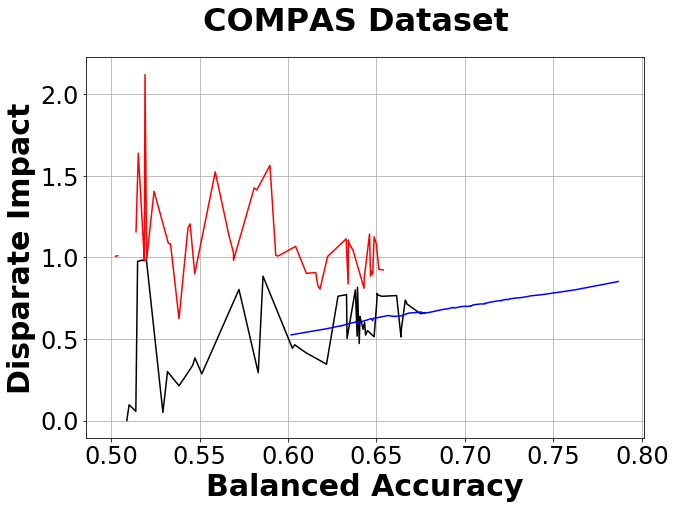

In [7]:
Data_Name = 'COMPAS_Random'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'disp-imp'

mx = df.sort_values(by=x_axis)

orig_array = transf_data_info['orig_array']
trans_array = transf_data_info['trans_array']
orig_sort = orig_array[orig_array[:,2].argsort()]
trans_sort = trans_array[trans_array[:,2].argsort()]

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('COMPAS Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

# ax1.plot(orig_sort[:,3], orig_sort[:,5],'--', color='k', label='Original Data')
# ax1.plot(trans_sort[:,3], trans_sort[:,5],'--', color='r', label='Re-weight Data')
# ax1.plot(orig_sort[:,3], orig_sort[:,8], color='k', label='Re-weight Data')
# ax1.plot(trans_sort[:,3], trans_sort[:,8], color='r', label='Re-weight Data')
ax1.plot(orig_sort[:,2], orig_sort[:,4], color='k', label='Re-weight Data')
ax1.plot(trans_sort[:,2], trans_sort[:,4], color='r', label='Re-weight Data')

# ax1.plot(mx[x_axis], mx['mean_test_acc'], color='k', label='Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_ba'], '--', color='g', label='Bal. Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_pp'], color='r', label='Percent Pos.')
ax1.plot(mx[x_axis], mx['mean_test_di'], color='b', label='Mitiband Data')

now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_label}_{y_label}_og_miti_HO_{ratio}_{now}.png'
destination = file_loc + file_name
# plt.savefig(destination)

In [8]:
import pickle
filename = 'Grid_compas_step_2'
infile = open(filename,'rb')
grid_data_info = pickle.load(infile)
infile.close()

grid_dict = grid_data_info['sample_dict']
grid_dict

{'pp': [0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0],
 'pn': [1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16, 1.18, 1.2],
 'up': [1.0, 1.02, 1.04, 1.06, 1.08, 1.1],
 'un': [0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]}

In [11]:
#Example of HyperBand with Rand-Forest on Digits dataset
total_time = []
for i in range(10):
    start_time = time.time()

    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 0.5 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=0
    ne=1
    att=1

    is_distribution = True

    g_search = GridSearchCV(model, param_dist, scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=grid_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    g_search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po, ne, att)
    this_time = (time.time() - start_time)
    print(this_time)
    total_time.append(this_time)
    print(this_time)
print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

Num - configs before:  3234
30
67.72011089324951
67.72011089324951
Num - configs before:  3234
30
68.42668890953064
68.42668890953064
Num - configs before:  3234
30
68.2962749004364
68.2962749004364
Num - configs before:  3234
30
69.48856019973755
69.48856019973755
Num - configs before:  3234
30
70.37262344360352
70.37262344360352
Num - configs before:  3234
30
69.53332448005676
69.53332448005676
Num - configs before:  3234
30
68.73638415336609
68.73638415336609
Num - configs before:  3234
30
69.24744129180908
69.24744129180908
Num - configs before:  3234
30
71.66415119171143
71.66415119171143
Num - configs before:  3234
30
75.56317901611328
75.56317901611328
--- 69.90487384796143 seconds stdev: 2.284854140873609---


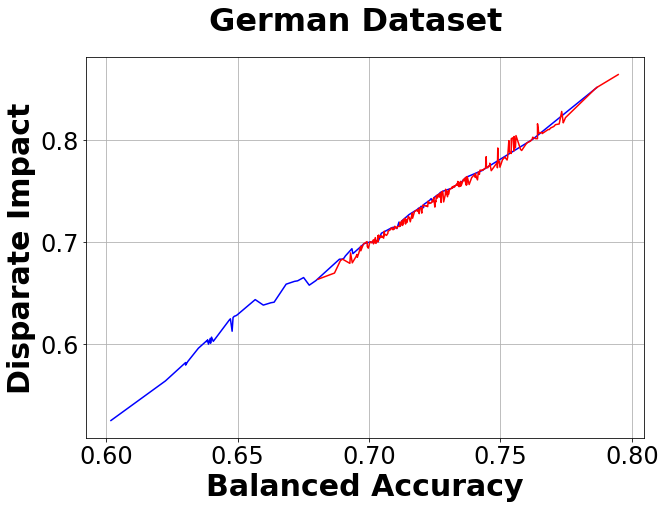

In [10]:
Data_Name = 'Compas_Grid'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'

df_grid = pd.DataFrame()
for dict_array in g_search.data_list:
    df_grid = pd.concat([df_grid, pd.DataFrame.from_dict(dict_array)], sort=False)
grid_mx = df_grid.sort_values(by=x_axis)


fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('German Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_axis, fontsize=30, fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

ax1.plot(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')
ax1.plot(grid_mx[x_axis], grid_mx['mean_test_di'], color='r', label='Disparate Imp.')

now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_og_miti_HO_{ratio}_{now}.png'
destination = file_loc + file_name
# plt.savefig(destination)

In [11]:
#Example of HyperBand with Rand-Forest on Digits dataset
total_time = []
for i in range(1):
    start_time = time.time()

    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 0.5 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=0
    ne=1
    att=1

    is_distribution = True
    if is_distribution:
        sample_dict = uniform_weights

    r_search = RandomizedSearchCV(model, param_dist, n_iter=121,
                               scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=sample_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    r_search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po=po, ne=ne, att=att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
# print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

3.26731014251709


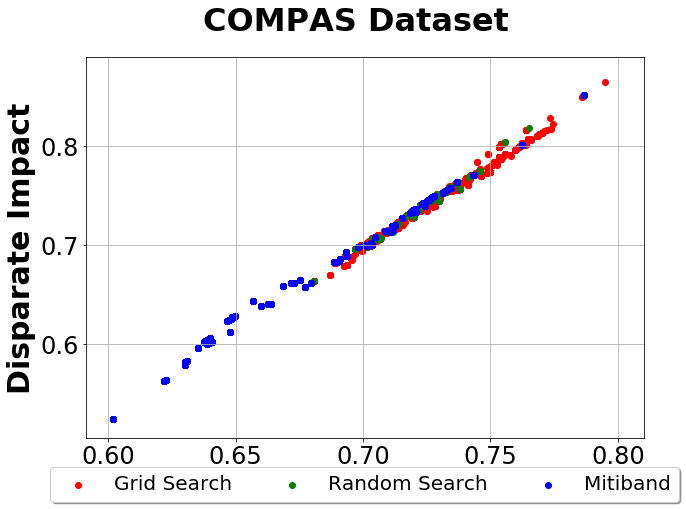

In [26]:
Data_Name = 'Compas_Grid_Rand'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'

df_rand = pd.DataFrame()
for dict_array in r_search.data_list:
    df_rand = pd.concat([df_rand, pd.DataFrame.from_dict(dict_array)], sort=False)
rand_mx = df_rand.sort_values(by=x_axis)

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('COMPAS Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_axis, fontsize=30, fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)


ax1.scatter(grid_mx[x_axis], grid_mx['mean_test_di'], color='r', label='Grid Search')
ax1.scatter(rand_mx[x_axis], rand_mx['mean_test_di'], color='g', label='Random Search')
ax1.scatter(mx[x_axis], mx['mean_test_di'], color='b', label='Mitiband')

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='20')

now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_time_complexity.png'
destination = file_loc + file_name
# plt.savefig(destination)
